In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 
from ply import write_ply

from utilities import *
from VoxelGrid import *
import os

from PIL import ImageFont
from PIL import ImageDraw 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'

N_points=200
dataset = "../nerf_synthetic/materials"

In [4]:
focal, all_c2w, all_gt = get_data(dataset)

LOAD DATA ../nerf_synthetic/materials/train


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.33it/s]


In [5]:
red = 8
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red)
im_w = target_ims[0].shape[0]
print(im_w)

red = 2
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
disp_im_w = disp_ims[0].shape[0]
print(disp_im_w)

100
400


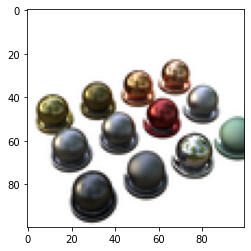

In [14]:
plt.imshow(target_ims[2])
plt.show()

In [15]:
test_focal, test_c2w, test_gt = get_data(dataset, "test")

LOAD DATA ../nerf_synthetic/materials/test


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 51.34it/s]


In [16]:
red = 4
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)
disp_im_w = disp_ims_test[0].shape[0]

In [17]:
D = RayDataset(target_ims, rays, device)
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=True)

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.35it/s]


In [113]:
class VoxelGrid_dev(VoxelGrid):
    def subdivide(self):
        with torch.no_grad():
            def old_flatten_3d(inds_3d):
                return inds_3d[...,0] + self.size//2*inds_3d[...,1] + self.size*self.size//4*inds_3d[...,2]



            old_ind = regular_3d_indexes(self.size)
            old_indm = regular_3d_indexes(self.size-1)

            self.size = 2 * self.size

            new_colors =  Variable(torch.zeros((self.size*self.size*self.size,3)).to(device), requires_grad=True)
            new_opacities =  Variable(torch.zeros((self.size*self.size*self.size)).to(device), requires_grad=True)

        
            target_inds = self.flatten_3d_indices(2*old_ind)
            new_colors[target_inds,:] = self.colors[:]
            new_opacities[target_inds] = self.opacities[:]

            # edges
            offsets = [np.array([1,0,0]),np.array([0,1,0]), np.array([0,0,1])]
            for off in offsets:
                c1_ind = old_flatten_3d(old_indm+off)
                c2_ind = old_flatten_3d(old_indm)
                
                target_inds = self.flatten_3d_indices(2*old_indm+off)
                new_colors[target_inds,:] = (self.colors[c1_ind,:]+self.colors[c2_ind,:])/2.0
                new_opacities[target_inds] = (self.opacities[c1_ind]+self.opacities[c2_ind])/2.0
                
            # Volume
            target_inds = self.flatten_3d_indices(2*old_indm+off[0]+off[1]+off[2])
            inds=[]
            inds.append(old_flatten_3d(old_indm+off[0]))
            inds.append(old_flatten_3d(old_indm+off[1]))
            inds.append(old_flatten_3d(old_indm+off[2]))
            inds.append(old_flatten_3d(old_indm))
            inds.append(old_flatten_3d(old_indm+off[0]+off[1]))
            inds.append(old_flatten_3d(old_indm+off[1]+off[2]))
            inds.append(old_flatten_3d(old_indm+off[2]+off[0]))
            inds.append(old_flatten_3d(old_indm+off[0]+off[1]+off[2]))
            
            new_colors[target_inds,:] = sum([self.colors[c_ind,:] for c_ind in inds])/8.0
            new_opacities[target_inds] = sum([self.opacities[c_ind] for c_ind in inds])/8.0

                
            offsets = [(np.array([1,0,0]),np.array([0,1,0]))
                       ,(np.array([0,1,0]),np.array([0,0,1]))
                       ,(np.array([0,0,1]),np.array([1,0,0]))]
            
            for (off1, off2) in offsets:
                c1_ind = old_flatten_3d(old_indm+off1)
                c2_ind = old_flatten_3d(old_indm+off2)
                c3_ind = old_flatten_3d(old_indm+off1+off2)
                c4_ind = old_flatten_3d(old_indm)
                
                target_inds = self.flatten_3d_indices(2*old_indm+off1+off2)
                new_colors[target_inds,:] = (self.colors[c1_ind,:]+self.colors[c2_ind,:]
                                            +self.colors[c3_ind,:]+self.colors[c4_ind,:])/4.0
                new_opacities[target_inds] = (self.opacities[c1_ind]+self.opacities[c2_ind]
                                             +self.opacities[c3_ind]+self.opacities[c4_ind])/4.0
                
            self.colors = new_colors
            self.opacities = new_opacities

    def render_rays(self, ordir_tuple, N_points, inv_depth=1.2):
        ori = ordir_tuple[0][:, None,:]
        
        # WARNING: Assuming constant distance
        distances = 10*torch.sqrt( (ordir_tuple[1]**2).sum(1, keepdim=True))/inv_depth/(N_points-1)
        scatter_points = torch.rand_like(distances)*distances + torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth

        p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])        
        with torch.no_grad():
            # extract valid indices
            inds_3d = torch.round(self.descartes_to_indices(p))
            in_bounds = self.in_bounds_indices(inds_3d)
            # meshgrid coordinates
            mesh_coords = self.flatten_3d_indices(inds_3d.long())
            mesh_coords[torch.logical_not(in_bounds)] = 0
        
        colors = self.colors[mesh_coords]
        opacities = self.opacities[mesh_coords]*in_bounds.float() # not_in bounds: 0 opacity
        
        opacities = opacities*distances
        cumsum_opacities = torch.cumsum(opacities, 1)
        
        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        return (colors*transp_term[..., None]).sum(1) + torch.exp(-cumsum_opacities[:, -1])[..., None]

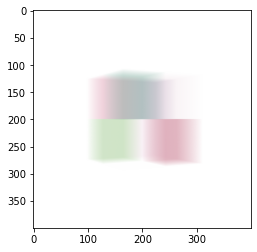

In [9]:
VG = VoxelGridSpherical(2, 0.5)


#VG.load('materials64.obj')

plt.imshow(VG.render_large_image_from_rays(disp_rays[18],(1000, 1.2)))

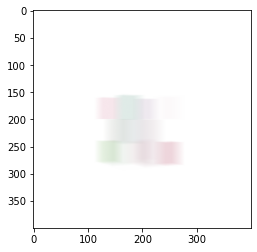

In [10]:
VG.subdivide()
plt.imshow(VG.render_large_image_from_rays(disp_rays[18],(1000, 1.2)))

In [7]:
VG2 = VoxelGrid(32, 1.2)
with torch.no_grad():
    VG2.size = VG.size
    VG2.colors[:] = VG.colors
    VG2.opacities[:] = VG.opacities


RuntimeError: expand(torch.cuda.FloatTensor{[4096, 3, 4]}, size=[32768, 3]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [38]:
#VG2.save('materials32&.obj')
#VG.subdivide()
#plt.imshow(VG.render_large_image_from_rays(disp_rays[10],(200, 1.2)))

In [27]:
VG.size

32

In [118]:
losses=[]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

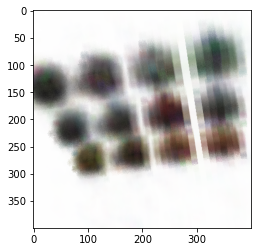

Train Epoch: 0 [0/200 (0%)]	Loss: 0.052322
Train Epoch: 0 [10/200 (5%)]	Loss: 0.043908
Train Epoch: 0 [20/200 (10%)]	Loss: 0.042031
Train Epoch: 0 [30/200 (15%)]	Loss: 0.041507
Train Epoch: 0 [40/200 (20%)]	Loss: 0.040700
Train Epoch: 0 [50/200 (25%)]	Loss: 0.041295
Train Epoch: 0 [60/200 (30%)]	Loss: 0.039714
Train Epoch: 0 [70/200 (35%)]	Loss: 0.038577
Train Epoch: 0 [80/200 (40%)]	Loss: 0.037537
Train Epoch: 0 [90/200 (45%)]	Loss: 0.037118
Train Epoch: 0 [100/200 (50%)]	Loss: 0.035839
Train Epoch: 0 [110/200 (55%)]	Loss: 0.037192
Train Epoch: 0 [120/200 (60%)]	Loss: 0.033512
Train Epoch: 0 [130/200 (65%)]	Loss: 0.035325
Train Epoch: 0 [140/200 (70%)]	Loss: 0.035067
Train Epoch: 0 [150/200 (75%)]	Loss: 0.035220


In [ ]:
N_points=200

optimizer = torch.optim.SGD(
            [VG.colors, VG.opacities], 
            lr=1000
        )

def train(epoch):
    losses=[]
    for batch_idx, (rays, pixels) in enumerate(train_loader):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        optimizer.zero_grad()
        
        pix_estims = VG.render_rays(rays, (N_points))
        
        loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0] +0.0001*VG.total_variation()
        #loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0]
        loss.backward()
        losses.append(loss.item())
        #VG.update_grads(1000)
        optimizer.step()
        VG.clamp()
        if batch_idx%10==0:
            print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx,
                        len(train_loader),
                        100.0 * batch_idx / len(train_loader),
                        loss.data.item(),
                    )
                )
    return losses

for epoch in tqdm(range(1)):
    new_im = VG.render_large_image_from_rays(disp_rays[0],(200,1.2))
    #VG.treshold_opacity(0.2)
    plt.imshow(new_im)
    plt.show()
    #plt.imsave('screenshots/a'+str(epoch)+'.png', new_im)



    losses += train(epoch)
    #VG.save('80_'+str(epoch)+'.obj')
    
    

Text(0.5, 0, 'Iterations')

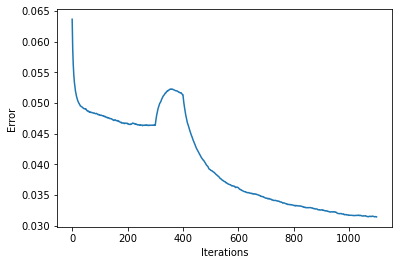

In [29]:
def rolling_average(p, k=100):
    p2 = np.zeros((p.shape[0]-k))
    for i in range(k):
        p2 += p[i:-(k-i)]
    return p2/k

plt.plot(rolling_average(np.array(losses)))




plt.ylabel("Error")
plt.xlabel("Iterations")
#plt.savefig('exports/2epochs_32.png')

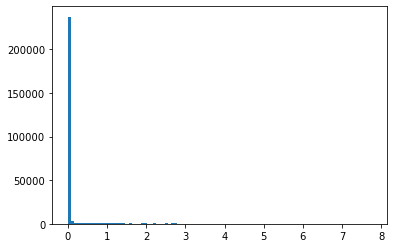

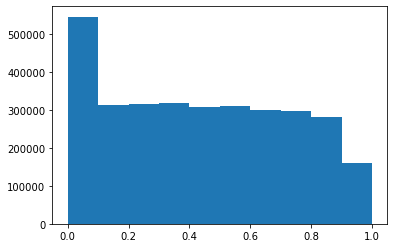

In [40]:
plt.hist(VG.opacities.tolist(), bins=100)
plt.show()
plt.hist(VG.colors.flatten().tolist())
plt.show()




In [28]:
VG2.save_magica_vox(0.4)
#VG.save('.obj')

100%|███████████████████████████████████████████| 64/64 [00:25<00:00,  2.51it/s]


In [26]:
c = VG2.make_palette(16)

ValueError: Image RGB array must be uint8 or floating point; found int64

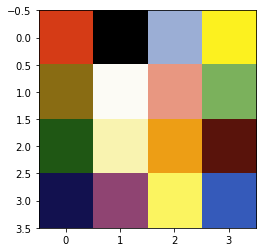

In [27]:
plt.imshow(c[1][:,:3].reshape((4,4,3)))

#plt.imsave('exporsts/64_best_palette.png', c[1][:,:3].reshape((4,4,3)))

In [22]:
all_c2w[image_ind]

disp_rays[image_ind][0][0,:,0]**2

array([8.33201508, 6.31625955, 1.60172607])

In [91]:
VG.save('materials64_sph.obj')

# TEST

In [10]:
VG2 = VoxelGrid()
VG2.load('64_best.obj')
VG2.bound_w

1.2

In [22]:
len(disp_ims_test)

200

In [22]:
VG2 = VoxelGrid()
VG2.load('materials64.obj')

In [130]:
VG2 = VG.copy()
VG.subdivide()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


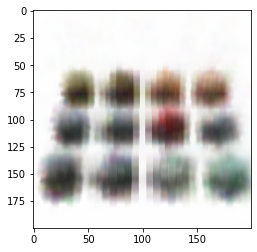

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


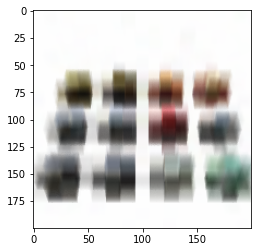

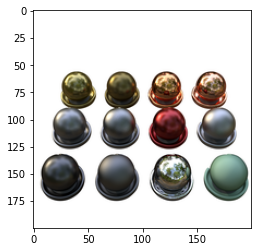

In [131]:
image_ind=0

new_im = VG.render_large_image_from_rays(disp_rays_test[image_ind],(1000,1.2))
new_im2 = VG2.render_large_image_from_rays(disp_rays_test[image_ind],(1000,1.2))


plt.imshow(new_im)
plt.show()
plt.imshow(new_im2)
plt.show()

plt.imshow(disp_ims_test[image_ind])

# ROTATION

In [11]:
rays_or_dir = [get_rays_np(800,800, focal, c2w) for c2w in all_c2w]

In [12]:
camera_centers = get_cameras_centers(rays_or_dir)

[3.8 0.  1. ]


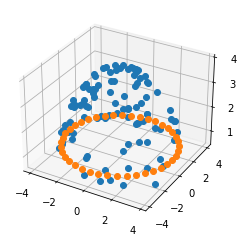

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:, 1], camera_centers[:,2], 'o')

n = 40
t = np.linspace(0,2*np.pi, n+1)[:-1]
cust_centers = np.zeros((n,3))
cust_centers[:,0] = np.cos(t)*3.8
cust_centers[:,1] = np.sin(t)*3.8
cust_centers[:,2] = 1

cust_c2ws = [create_rotation_transformation_matrix(cust_centers[i], t[i], -np.pi*0.1) for i in range(n)]

ax.plot( cust_centers[:,0], cust_centers[:,1], cust_centers[:,2], 'o')

print(cust_centers[0])



In [59]:
cust_c2ws = create_rotation_matrices(1,-10, n=60)

In [65]:
red_fac=4
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))



In [100]:

VG = VoxelGrid(100, 1)
VG.load('materials64.obj')

In [44]:
VG.total_variation()

tensor(0.2183, device='cuda:0', grad_fn=<DivBackward0>)

In [67]:
imgs=[]
for image_ind in tqdm(range(len(cust_c2ws))):
    with torch.no_grad():
        new_im = VG.render_large_image_from_rays(ordir_rays[image_ind],(500, 1.2))
        #new_im = VG.render_image_from_rays(ordir_rays[image_ind],(200, 1.2))
        #plt.imshow(new_im)
        #plt.show()
        imgs.append(new_im)

100%|███████████████████████████████████████████| 60/60 [06:05<00:00,  6.10s/it]


In [68]:
imageio.mimwrite('screenshots/materials2.gif', imgs,  format='GIF', duration=0.1)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [12]:
L=[]
k=0
i=0
while i<39:
    k+=1
    for _ in range(4):
        L.append(i)
        i+=k
L

[0, 1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 21, 24, 28, 32, 36]

In [66]:

images=[]
for ind in tqdm(L):
    VG.load('64a_'+str(ind)+'.obj')
    for image_ind in (range(len(cust_c2ws))):
        new_im = VG.render_image_from_rays(ordir_rays[image_ind], (1000, 2))
        img = Image.fromarray(np.uint8(255*new_im))
        draw = ImageDraw.Draw(img)
        draw.text((10, 10),"Epoch:"+str(ind),(255,255,255))
        images.append(np.array(img))
        #plt.imshow(images[-1])
        #plt.show()
        #images.append(np.uint8(255*new_im))
        plt.imsave('screenshots/rotate/'+str(ind)+'_'+str(image_ind)+'.png', new_im)


NameError: name 'L' is not defined

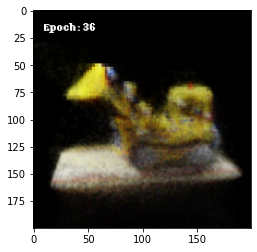

In [20]:
plt.imshow(images[-1])

In [19]:
imageio.mimwrite('screenshots/movies.gif', images,  format='GIF', duration=0.1)

# Interp

In [33]:
class Voxel_dev(VoxelGridSpherical):
    def in_bounds_indices(self, p):
        ''' input: Nx3 array
            output: index of valid arrays'''
        in_x = (p[...,0]>=0)*(p[...,0]<(self.size-1))
        in_y = (p[...,1]>=0)*(p[...,1]<(self.size-1))
        in_z = (p[...,2]>=0)*(p[...,2]<(self.size-1))
        return in_x*in_y*in_z
   

    def render_rays(self, ordir_tuple, N_points, inv_depth=1.2):

        ori = ordir_tuple[0][:, None,:]

        # WARNING: Assuming constant distance
        distances = 10*torch.sqrt( (ordir_tuple[1]**2).sum(1, keepdim=True))/inv_depth/(N_points-1)
        scatter_points = torch.rand_like(distances)*distances + torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth
        p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])
        
        offsets = [np.array([0,0,0]), 
                   np.array([1,0,0]), 
                   np.array([0,0,1]),
                   np.array([1,0,1]),
                   np.array([0,1,0]),
                   np.array([1,1,0]),  
                   np.array([0,1,1]),
                   np.array([1,1,1])]
        #indicies
        p = self.descartes_to_indices(p)   
        p0 = torch.floor(p)
        in_bounds = self.in_bounds_indices(p)
        diff = (p-p0)
        ind_offsets = []
        for i in range(8):
            mesh_coords = self.flatten_3d_indices(p0+torch.tensor(offsets[i]).to(device)).long()
            mesh_coords[torch.logical_not(in_bounds)] = 0
            ind_offsets.append(mesh_coords)


        harmonics = self.view_harmonics(p[0,0])
        
        
        
        # color interp
        ciii = [torch.tensordot(self.colors[ind_offsets[i]],harmonics, dims=([-1], [0]))
                *(1-diff[...,0, None])+
                torch.tensordot(self.colors[ind_offsets[i+1]],harmonics, dims=([-1], [0]))
                *diff[...,0, None] for i in range(0,8,2)]
        cii = [ciii[i]*(1-diff[...,1, None]) + ciii[i+2]*diff[...,1, None] for i in [0,1]]
        colors = cii[0]*(1-diff[...,2, None])+cii[1]*diff[...,2, None]
        
        # opacities interp
        ciii = [self.opacities[ind_offsets[i]]
                *(1-diff[...,0]) +
                self.opacities[ind_offsets[i+1]]
                *diff[...,0] for i in range(0,8,2)]
        cii = [ciii[i]*(1-diff[...,1]) + ciii[i+2]*diff[...,1] for i in [0,1]]
        opacities = (cii[0]*(1-diff[...,2])+cii[1]*diff[...,2])
        
        opacities = opacities*distances*in_bounds.float() # REMOVE
        cumsum_opacities = torch.cumsum(opacities, 1)

        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        return (colors*transp_term[..., None]).sum(1)
    


In [40]:
VG = VoxelGridSpherical()
VG.load('sph64_best.obj')

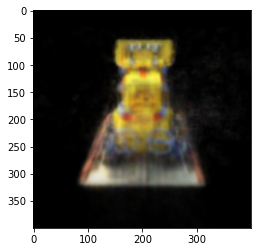

In [47]:
VG2 = Voxel_dev(64, 1.2)
with torch.no_grad():
    VG2.colors[:] = VG.colors[:]
    VG2.opacities[:] = VG.opacities[:]
plt.imshow(VG2.render_large_image_from_rays(disp_rays[0], (1000, 1.2)))

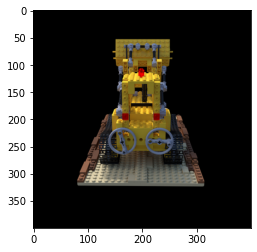

In [48]:
plt.imshow(disp_ims[0])

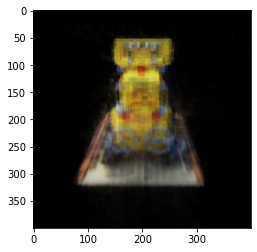

In [25]:
plt.imshow(VG.render_large_image_from_rays(disp_rays[0], (500, 1.2)))

In [64]:
values_arr = torch.rand((10000, 3, 4))

In [72]:
p = torch.rand((10,3))*100

In [79]:
p0.shape

torch.Size([10, 3])

In [85]:
values_arr.shape

#diff[...,0].shape

torch.Size([10000, 3, 4])

In [89]:
values_arr[ind_offsets[0]].shape

torch.Size([10, 3, 4])